In [16]:
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import pandas.io.sql as sqlio
import os
from dotenv import load_dotenv
import datetime as dt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, Birch
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pickle as pkl
import json

In [17]:
RANDOM_STATE = 42

# Read Data

In [18]:
# Curry function to initialize postgres engine and return read_query function

def make_read_query(protocol=None, user=None, password=None, host=None, port=None, db=None):
    load_dotenv()
    
    protocol = protocol if protocol else 'postgresql+psycopg2'
    user = user if user else os.environ.get('POSTGRES_USER')
    password = password if password else os.environ.get('POSTGRES_PASSWORD')
    host = host if host else 'localhost'
    port = port if port else 5432
    db = db if db else os.environ.get('POSTGRES_DB')
    
    db_url = f'{protocol}://{user}:{password}@{host}:{port}/{db}'
    engine = create_engine(db_url)

    def read_query(query, verbose=True):
        if verbose:
            print(query, '\n')
            
        with engine.connect() as conn:
            df = sqlio.read_sql_query(query, conn)

        return df

    return read_query

In [19]:
read_query = make_read_query()

In [20]:
users_enriched = read_query("SELECT * FROM users_enriched")
users_enriched.head()

SELECT * FROM users_enriched 



,id,age,gender,country,city,traffic_source,created_at,first_order_timestamp,last_order_timestamp,days_to_activation,...,fav_category,fav_cat_purchases,fav_cat_avg_item_value,fav_cat_freq_strength,fav_cat_spending_strength,order_items,loyalty_segment,order_value_segment,category_choice_segment,lifetime_status
0,36877,58,F,France,Athée-sur-Cher,Organic,2019-07-06 09:08:00,2022-01-26 15:06:02,2023-08-09 10:41:01,935.0,...,Active,2.0,32.500,0.250000,0.267721,"{""(121059,\""Key Industries Men's Big-Tall Flan...",None,None,None,None
1,23177,16,F,Brasil,Três Corações,Search,2019-07-06 09:17:00,NaT,NaT,NaN,...,None,NaN,NaN,NaN,NaN,None,None,None,None,None
2,90016,46,M,China,Ordos,Search,2019-07-06 09:17:00,2021-05-31 21:53:07,2022-12-21 13:00:24,695.0,...,Jeans,1.0,148.990,0.200000,0.457614,"{""(91702,\""Pendleton Men's Weekender Zip-front...",None,None,None,None
3,81819,27,F,United States,East Hartford,Search,2019-07-06 09:31:00,2020-10-15 09:08:14,2023-07-18 10:23:15,466.0,...,Swim,2.0,105.125,0.333333,0.683451,"{""(102471,\""Maidenform Control It! Wear Your O...",None,None,None,None
4,95560,43,M,Spain,Madrid,Search,2019-07-06 10:16:00,NaT,NaT,NaN,...,None,NaN,NaN,NaN,NaN,None,None,None,None,None


In [21]:
users_enriched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84011 entries, 0 to 84010
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         84011 non-null  int64         
 1   age                        84011 non-null  int64         
 2   gender                     84011 non-null  object        
 3   country                    84011 non-null  object        
 4   city                       84011 non-null  object        
 5   traffic_source             84011 non-null  object        
 6   created_at                 84011 non-null  datetime64[ns]
 7   first_order_timestamp      58293 non-null  datetime64[ns]
 8   last_order_timestamp       58293 non-null  datetime64[ns]
 9   days_to_activation         58293 non-null  float64       
 10  active_days                58293 non-null  float64       
 11  inactive_days              58293 non-null  float64       
 12  avg_

In [22]:
users_enriched.describe()

,id,age,created_at,first_order_timestamp,last_order_timestamp,days_to_activation,active_days,inactive_days,avg_days_to_order,std_days_to_order,...,max_order_items,avg_item_value,max_item_value,avg_order_value,max_order_value,n_categories,fav_cat_purchases,fav_cat_avg_item_value,fav_cat_freq_strength,fav_cat_spending_strength
count,84011.000000,84011.000000,84011,58293,58293,58293.000000,58293.000000,58293.000000,21899.000000,58293.000000,...,58293.000000,58293.000000,58293.000000,58293.000000,58293.00000,58293.000000,58293.000000,58293.000000,58293.000000,58293.000000
mean,50064.425611,41.062706,2021-06-14 10:42:19.902130432,2022-08-02 13:44:07.089472768,2023-01-06 23:26:35.611470848,430.072530,157.218071,786.071072,286.277227,25.738270,...,1.638224,59.397607,87.070144,86.045600,107.95719,2.140531,1.107886,83.644216,0.210737,0.323130
min,1.000000,12.000000,2019-01-02 00:06:00,2019-01-06 02:25:41,2019-01-06 02:25:41,0.000000,0.000000,406.000000,0.000000,0.000000,...,1.000000,0.020000,0.020000,0.020000,0.02000,1.000000,1.000000,0.020000,0.000000,0.000000
25%,25108.500000,26.000000,2020-02-20 04:11:00,2021-10-12 13:24:51,2022-07-01 13:01:12,103.000000,0.000000,487.000000,84.000000,0.000000,...,1.000000,29.945000,34.990000,34.990000,38.00000,1.000000,1.000000,34.000000,0.000000,0.000000
50%,50099.000000,41.000000,2021-05-23 03:56:00,2022-11-11 09:55:21,2023-05-16 14:03:19,310.000000,0.000000,656.000000,205.000000,0.000000,...,1.000000,46.470000,60.000000,62.000000,74.74000,2.000000,1.000000,59.500000,0.200000,0.357341
75%,75017.500000,56.000000,2022-09-24 04:51:30,2023-08-09 14:54:31,2023-11-02 00:05:26,659.000000,172.000000,975.000000,403.000000,0.000000,...,2.000000,70.983333,109.990000,109.350000,144.29000,3.000000,1.000000,102.990000,0.500000,0.604599
max,100000.000000,70.000000,2024-01-16 19:46:14.316147,2024-01-21 10:09:51.990337,2024-01-21 12:55:19.720387,1828.000000,1759.000000,2248.000000,1744.000000,1222.000000,...,4.000000,999.000000,999.000000,1341.490000,1347.29000,18.000000,7.000000,999.000000,0.833333,0.999558
std,28864.127943,17.034090,NaN,NaN,NaN,399.416052,305.310117,377.715482,274.826897,90.569301,...,0.923900,53.434791,88.762539,83.088805,108.72422,1.469215,0.352533,85.145930,0.217530,0.321335


# EDA

In [23]:
inactive_users = users_enriched.loc[users_enriched.n_orders==0].copy()
one_off_customers = users_enriched.loc[users_enriched.n_orders==1].copy()
repeat_purchasers = users_enriched.loc[users_enriched.n_orders>1].copy()

print('Repeat Purchasers:', repeat_purchasers.shape[0], 
      'One-Off Customers', one_off_customers.shape[0], 
      'Inactive Users', inactive_users.shape[0])

Repeat Purchasers: 21899 One-Off Customers 36394 Inactive Users 25718


In [24]:
one_off_customers['segment'] = 'One-Off Customers'
inactive_users['segment'] = 'Never Ordered'

In [25]:
CLUSTERING_FEATURES = ['n_orders', 'avg_days_to_order', 
                       'avg_order_items', 'max_order_items', 'avg_item_value', 'max_item_value',
                       'n_categories', 'fav_category', 'fav_cat_purchases', 'fav_cat_freq_strength', 'fav_cat_spending_strength']
X = repeat_purchasers[CLUSTERING_FEATURES]
X_num = X.drop(columns=['fav_category'])

In [26]:
X_num.describe()

,n_orders,avg_days_to_order,avg_order_items,max_order_items,avg_item_value,max_item_value,n_categories,fav_cat_purchases,fav_cat_freq_strength,fav_cat_spending_strength
count,21899.000000,21899.000000,21899.000000,21899.000000,21899.000000,21899.000000,21899.000000,21899.000000,21899.000000,21899.000000
mean,2.634504,286.277227,1.562537,1.956436,59.726520,115.483605,3.362528,1.233253,0.353302,0.555829
std,1.133329,274.826897,0.658002,1.015058,38.024806,100.995169,1.559091,0.499911,0.149068,0.188636
min,2.000000,0.000000,1.000000,1.000000,4.470000,5.950000,1.000000,1.000000,0.000000,0.000000
25%,2.000000,84.000000,1.000000,1.000000,36.225000,55.000000,2.000000,1.000000,0.250000,0.428467
50%,2.000000,205.000000,1.000000,2.000000,51.195000,88.950000,3.000000,1.000000,0.333333,0.551100
75%,3.000000,403.000000,2.000000,2.000000,72.040143,148.000000,4.000000,1.000000,0.500000,0.688112
max,25.000000,1744.000000,4.000000,4.000000,571.500000,999.000000,18.000000,7.000000,0.833333,0.989280


In [27]:
def plot_histograms(df, columns=None, width=14, height=7, bins=20):
    columns = df.columns if columns is None else columns
    n_subplots = len(columns)
    n_subplot_rows = round(np.sqrt(n_subplots))
    n_subplot_cols = n_subplots / n_subplot_rows

    n_subplot_cols = int(n_subplot_cols) + 1 if n_subplot_cols % 1 > 0 else int(n_subplot_cols)
    
    fig, axs = plt.subplots(n_subplot_rows, n_subplot_cols)
    fig.set_figwidth(14)
    fig.set_figheight(7)
    fig.subplots_adjust(wspace=0.3, hspace=0.3)

    for i, col in enumerate(columns):
        ax_row = i // n_subplot_cols
        ax_col = i % n_subplot_cols
        ax = axs[ax_row,ax_col]
        ax.set_title(col)
        df[col].hist(bins=bins, ax=ax)

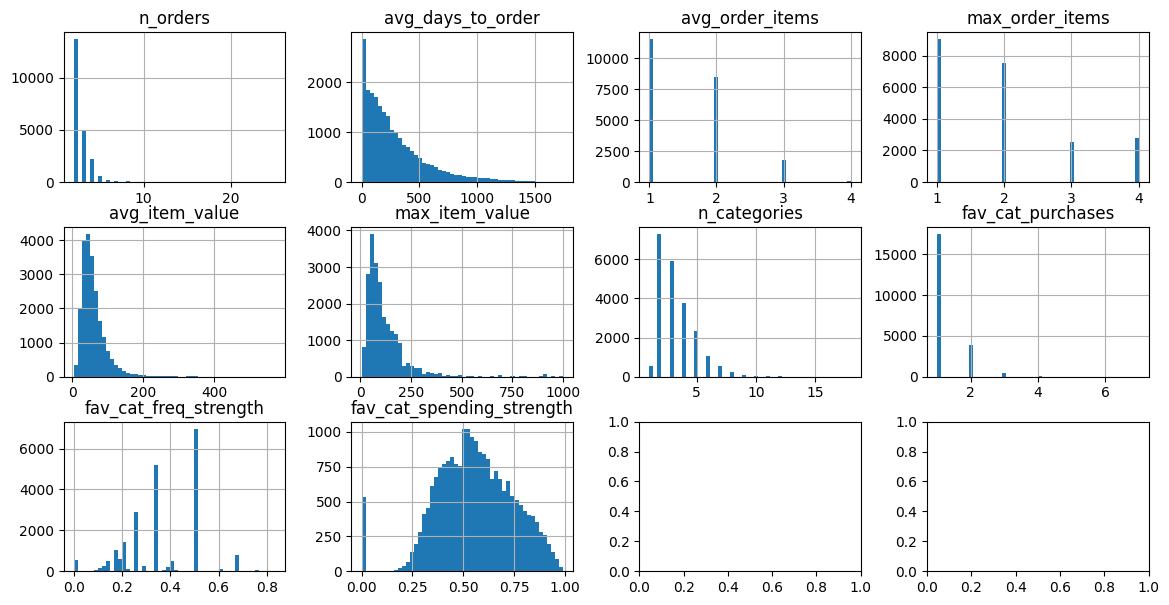

In [28]:
plot_histograms(X_num, bins=50)

<Axes: xlabel='n_orders', ylabel='avg_days_to_order'>

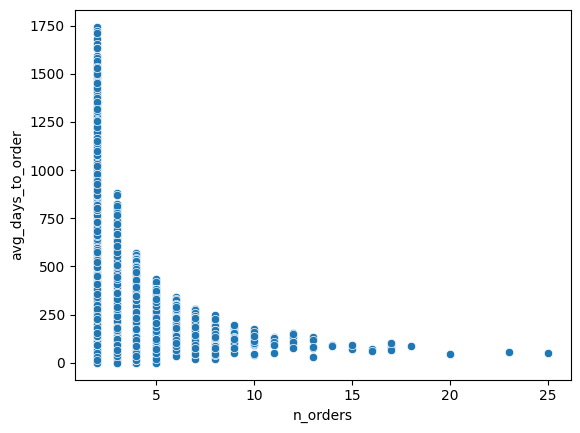

In [29]:
sns.scatterplot(X, x='n_orders', y='avg_days_to_order')

<Axes: xlabel='n_orders', ylabel='std_days_to_order'>

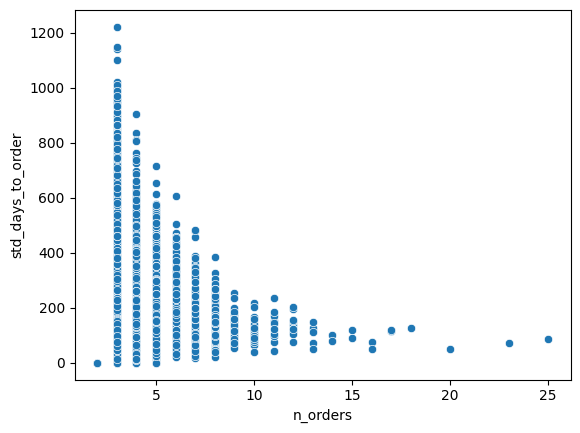

In [30]:
sns.scatterplot(repeat_purchasers, x='n_orders', y='std_days_to_order')

<Axes: xlabel='avg_days_to_order', ylabel='std_days_to_order'>

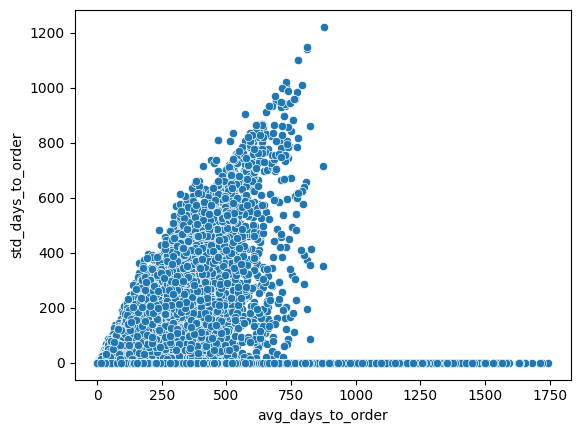

In [31]:
sns.scatterplot(repeat_purchasers, x='avg_days_to_order', y='std_days_to_order')

<Axes: xlabel='n_orders', ylabel='avg_order_items'>

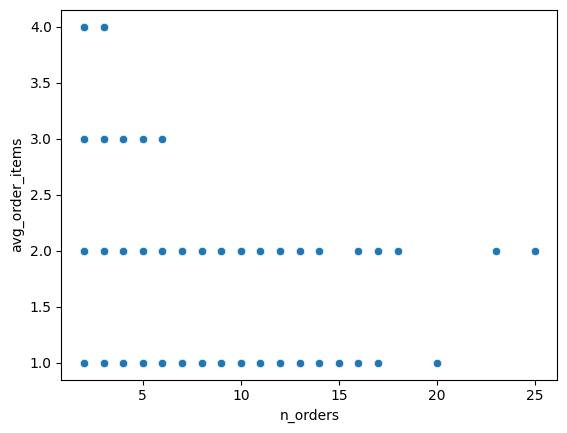

In [32]:
sns.scatterplot(X, x='n_orders', y='avg_order_items')

<Axes: xlabel='n_orders', ylabel='max_order_items'>

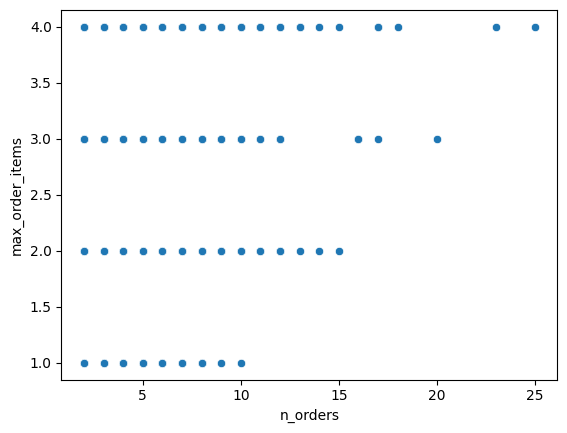

In [33]:
sns.scatterplot(X, x='n_orders', y='max_order_items')

<Axes: xlabel='n_orders', ylabel='avg_item_value'>

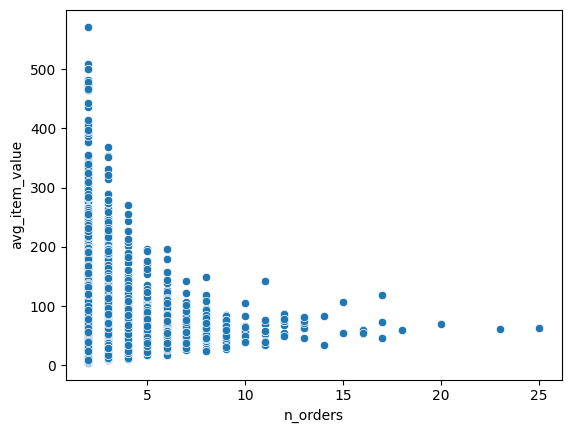

In [34]:
sns.scatterplot(X, x='n_orders', y='avg_item_value')

<Axes: xlabel='n_orders', ylabel='max_item_value'>

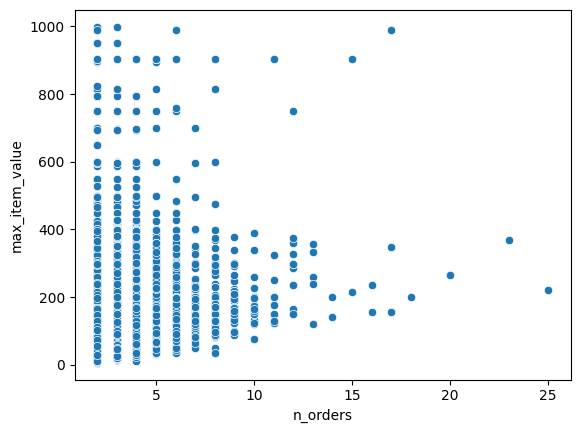

In [35]:
sns.scatterplot(X, x='n_orders', y='max_item_value')

<Axes: xlabel='avg_order_items', ylabel='avg_item_value'>

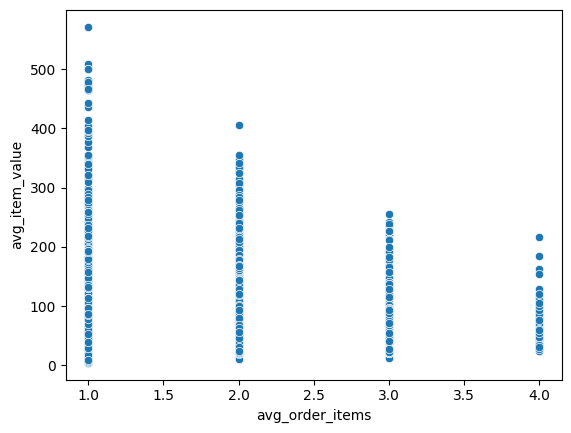

In [36]:
sns.scatterplot(X, x='avg_order_items', y='avg_item_value')

<Axes: xlabel='max_order_items', ylabel='max_item_value'>

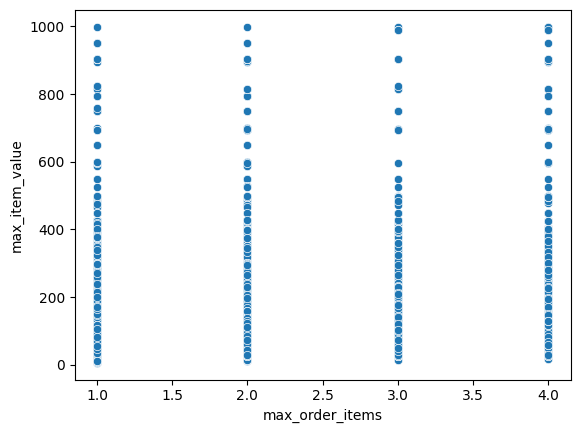

In [37]:
sns.scatterplot(X, x='max_order_items', y='max_item_value')

<Axes: >

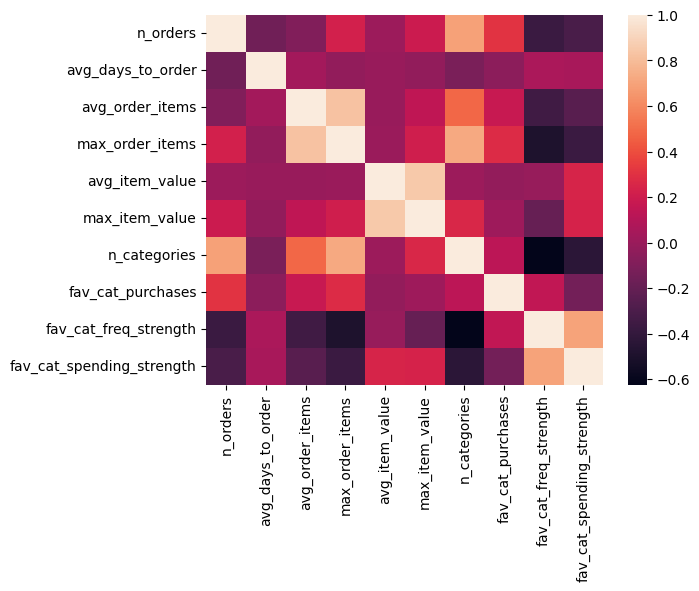

In [38]:
sns.heatmap(X_num.corr())

<Axes: xlabel='n_orders', ylabel='fav_cat_purchases'>

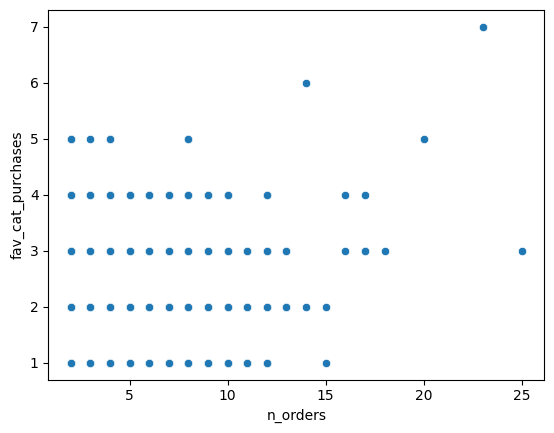

In [39]:
sns.scatterplot(X, x='n_orders', y='fav_cat_purchases')

<Axes: xlabel='fav_cat_purchases', ylabel='n_categories'>

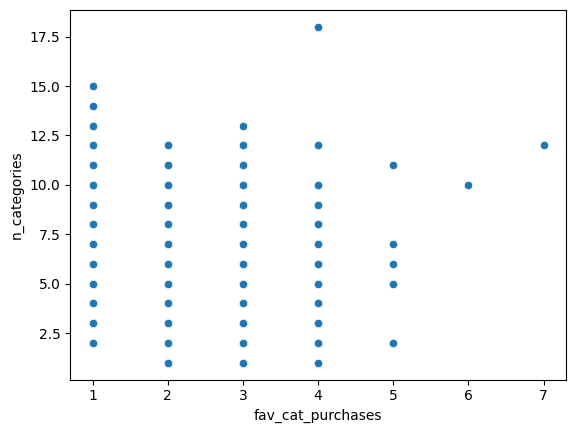

In [40]:
sns.scatterplot(X, x='fav_cat_purchases', y='n_categories')

<Axes: xlabel='n_categories', ylabel='fav_cat_freq_strength'>

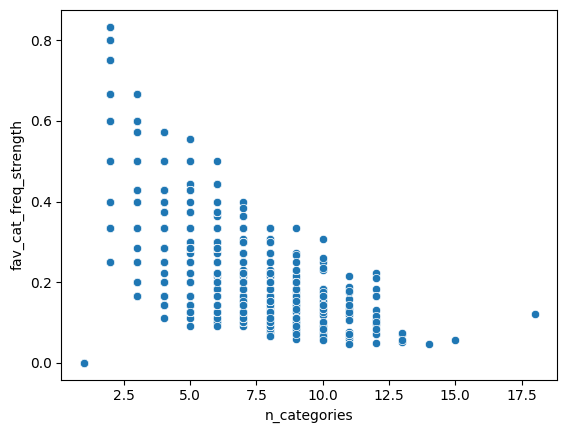

In [41]:
sns.scatterplot(X, x='n_categories', y='fav_cat_freq_strength')

<Axes: xlabel='n_categories', ylabel='fav_cat_spending_strength'>

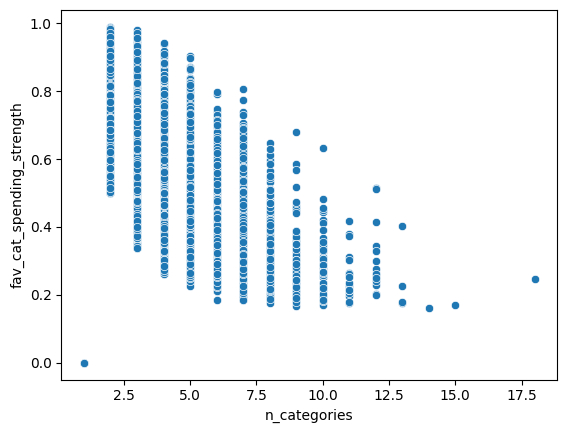

In [42]:
sns.scatterplot(X, x='n_categories', y='fav_cat_spending_strength')

<Axes: xlabel='fav_cat_purchases', ylabel='pct_cumsum'>

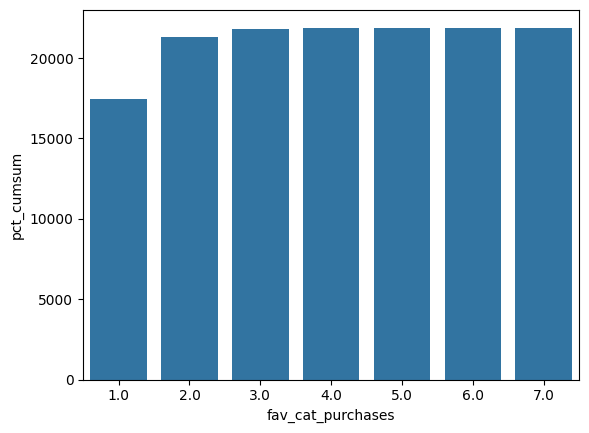

In [43]:
n_cat_purchase_counts = X.fav_cat_purchases.value_counts().reset_index().sort_values('fav_cat_purchases')
n_cat_purchase_counts['pct_cumsum'] = n_cat_purchase_counts['count'].cumsum()
sns.barplot(n_cat_purchase_counts, x='fav_cat_purchases', y='pct_cumsum')

<Axes: xlabel='n_categories', ylabel='pct_cumsum'>

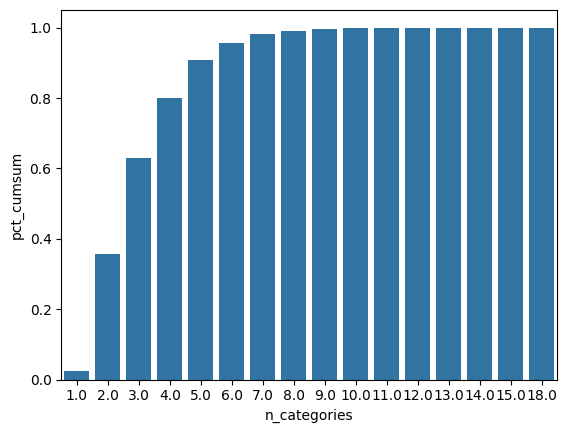

In [44]:
n_cat_counts = X.n_categories.value_counts().reset_index().sort_values('n_categories')
n_cat_counts['pct_cumsum'] = n_cat_counts['count'].cumsum() / n_cat_counts['count'].sum()
sns.barplot(n_cat_counts, x='n_categories', y='pct_cumsum')

# Segmenting Repeat Purchasers by Loyalty & Order Value

In [49]:
def model_results_to_df(results, explode_hyperparams=True):
    df = pd.DataFrame(results)
    if explode_hyperparams:
        df_hyperparams = pd.DataFrame(df['hyperparams'].tolist())
        df = pd.concat([df, df_hyperparams], axis=1)\
                .drop(columns='hyperparams')
    return df

def search_clustering_hyperparams(model_type, hyperparams, X, random_state=None, verbose=True, explode_hyperparams=True):
    results = []
    for hyperparams_iter in hyperparams:
        if random_state:
            hyperparams_iter['random_state'] = random_state
            
        model = model_type(**hyperparams_iter)
        y = model.fit_predict(X)

        if model_type != KModes:
            silhouette = silhouette_score(X, y)
        else:
            silhouette = None
        
        if model_type == KMeans:
            error = model.inertia_ 
        elif model_type == KModes:
            error = model.cost_
        else:
            error = None
            
        results_dict = { 
            'hyperparams': hyperparams_iter, 
            'model': model,
            'silhouette_score': silhouette,
            'error': error
        }
        
        
        results.append(results_dict)

        if verbose:
            print(hyperparams_iter, f'Silhouette Score: {silhouette}', f'Error: {error}', sep=' | ')

    df_results = model_results_to_df(results, explode_hyperparams=True)
    
    return df_results

In [50]:
def plot_clusters(X, y, figwidth=15, figheight=10, bins=20):
    X = pd.DataFrame(X) if type(X) != pd.DataFrame else X
    labels = np.unique(y)

    fig, axs = plt.subplots(len(labels), len(X.columns))
    fig.set_figwidth(figwidth)
    fig.set_figheight(figheight)
    fig.suptitle('Cluster Feature Histograms')
    fig.subplots_adjust(wspace=0.3, hspace=0.3)

    col_mins = {}
    col_maxs = {}
    col_means = {}
    for col in X.columns:
        col_mins[col] = X[col].min()
        col_maxs[col] = X[col].max()
        col_means[col] = X[col].mean()

    for i, label in enumerate(labels):
        X_cluster = X.loc[y==label]
        for j, col in enumerate(X.columns):        
            ax = axs[i,j]
            ax.set_xlim(col_mins[col], col_maxs[col])
            if j == 0:
                ax.set_ylabel(label)
            if i == len(labels) - 1:
                ax.set_xlabel(col)
            
            X_cluster[col].hist(ax=ax, bins=bins)
            cluster_col_mean = X_cluster[col].mean()
            ymax = pd.cut(X_cluster[col], bins).value_counts().max()
            ax.vlines(cluster_col_mean, ymin=0, ymax=ymax, color='tab:orange', label='Cluster Mean')
            ax.vlines(col_means[col], ymin=0, ymax=ymax, color='tab:red', label='Sample Mean')

    handles, labels = axs[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

## Customer Loyalty Segments

In [30]:
X_loyalty = repeat_purchasers[['n_orders', 'avg_days_to_order']]

In [53]:
scaler_loyalty = RobustScaler()
X_loyalty_scaled = scaler_loyalty.fit_transform(X_loyalty)
X_loyalty_scaled

array([[ 0.        ,  1.3322884 ],
       [ 0.        ,  0.15673981],
       [ 3.        ,  0.3354232 ],
       ...,
       [ 0.        , -0.64263323],
       [ 0.        , -0.64263323],
       [ 0.        , -0.64263323]], shape=(21899, 2))

In [54]:
hyperparams = [{'n_clusters': i} for i in range(2, 21)]
kmeans_results_loyalty = search_clustering_hyperparams(KMeans, hyperparams, X_loyalty_scaled, random_state=RANDOM_STATE)

{'n_clusters': 2, 'random_state': 42} | Silhouette Score: 0.5368197754425308 | Error: 27329.388580168037
{'n_clusters': 3, 'random_state': 42} | Silhouette Score: 0.5192682961304557 | Error: 16731.705888439676
{'n_clusters': 4, 'random_state': 42} | Silhouette Score: 0.5360680742511378 | Error: 11654.111462582032
{'n_clusters': 5, 'random_state': 42} | Silhouette Score: 0.5236634858607633 | Error: 9071.920113142203
{'n_clusters': 6, 'random_state': 42} | Silhouette Score: 0.5486242970109995 | Error: 7583.126133710337
{'n_clusters': 7, 'random_state': 42} | Silhouette Score: 0.5395815054174419 | Error: 6649.240383600038
{'n_clusters': 8, 'random_state': 42} | Silhouette Score: 0.5542603406032665 | Error: 4575.826565626011
{'n_clusters': 9, 'random_state': 42} | Silhouette Score: 0.5820332641445075 | Error: 3760.540070969768
{'n_clusters': 10, 'random_state': 42} | Silhouette Score: 0.5824071660513599 | Error: 2929.325932310994
{'n_clusters': 11, 'random_state': 42} | Silhouette Score: 0

<Axes: title={'center': 'Silhouette Score'}, xlabel='n_clusters'>

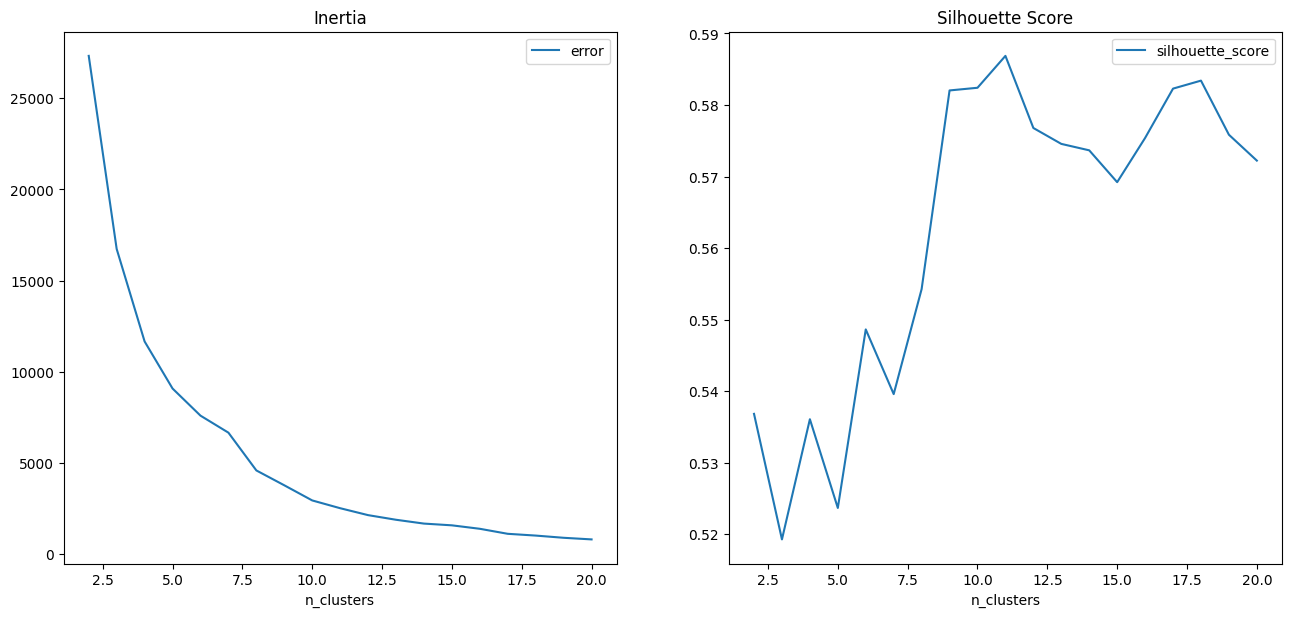

In [55]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.set_figheight(7)
plt.tight_layout(pad=5)

axs[0].set_title('Inertia')
kmeans_results_loyalty.plot(x='n_clusters', y='error', ax=axs[0])

axs[1].set_title('Silhouette Score')
kmeans_results_loyalty.plot(x='n_clusters', y='silhouette_score', ax=axs[1])

In [56]:
kmeans_loyalty = kmeans_results_loyalty.loc[kmeans_results_loyalty.n_clusters==11, 'model'].iloc[0]
Xy = X.copy()
Xy['segment'] = kmeans_loyalty.labels_
repeat_purchasers['loyalty_segment'] = kmeans_loyalty.labels_

In [57]:
cluster_centers = scaler_loyalty.inverse_transform(kmeans_loyalty.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns=['n_orders', 'avg_days_to_order'])
cluster_centers.sort_values(['n_orders', 'avg_days_to_order'])

,n_orders,avg_days_to_order
7,2.000000,79.989519
0,2.000000,337.298646
4,2.000000,1112.120120
8,2.003159,666.537906
6,3.000000,136.723048
2,3.011655,463.849068
5,4.000000,202.135220
1,5.301911,190.968153
10,7.386243,151.624339
3,10.253012,116.361446


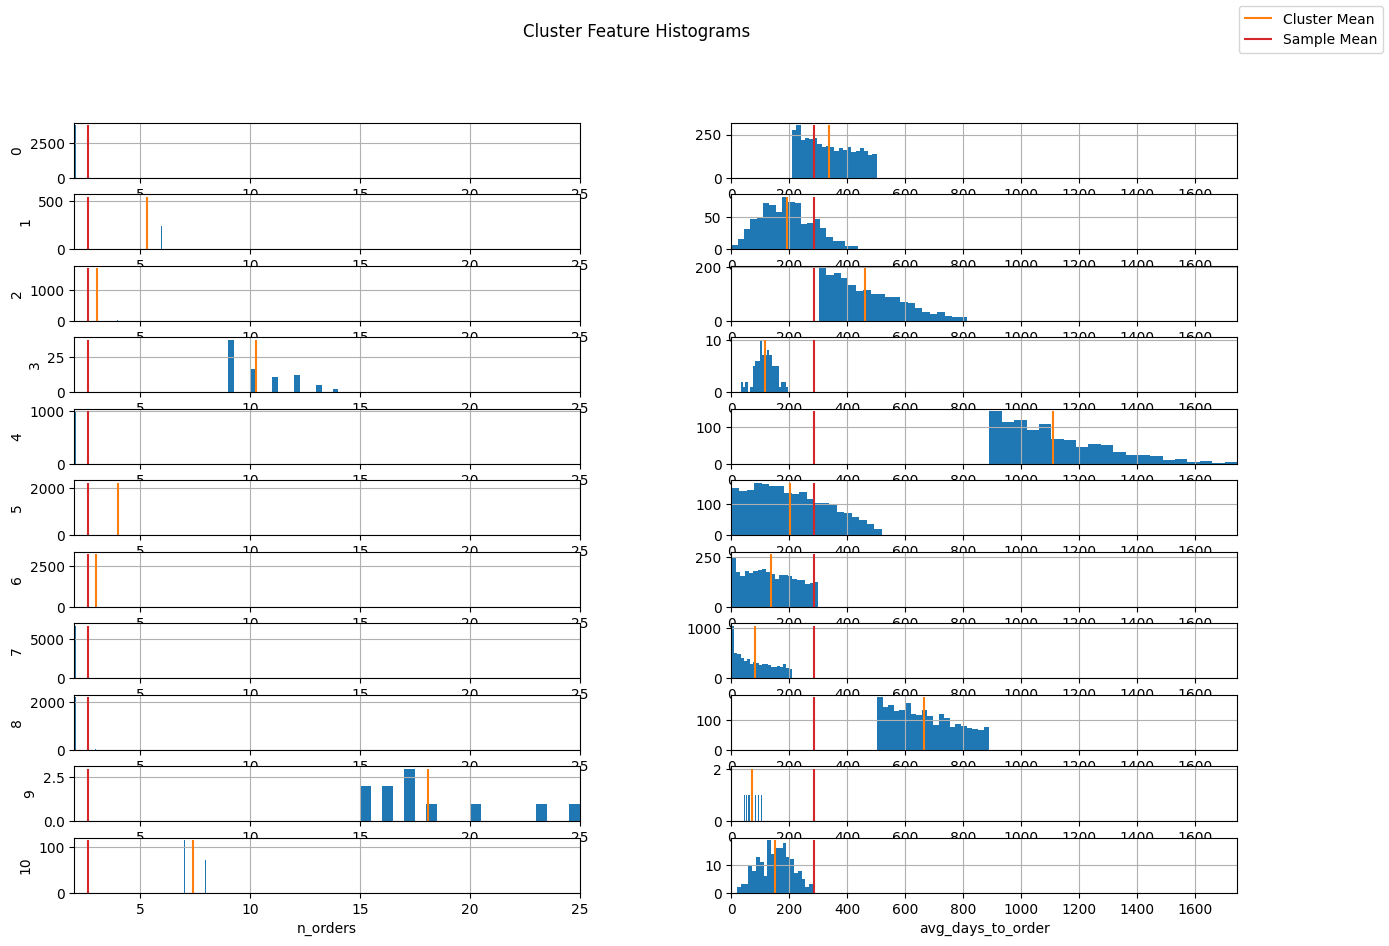

In [58]:
plot_clusters(X_loyalty, kmeans_loyalty.labels_)

<Axes: xlabel='n_orders', ylabel='avg_days_to_order'>

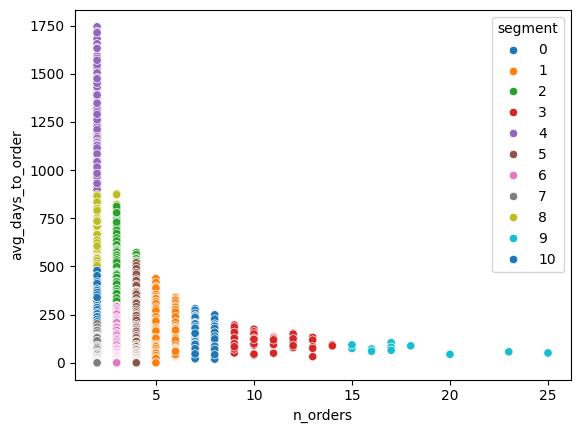

In [59]:
sns.scatterplot(Xy, x='n_orders', y='avg_days_to_order', hue='segment', palette='tab10')

<Axes: xlabel='n_orders', ylabel='std_days_to_order'>

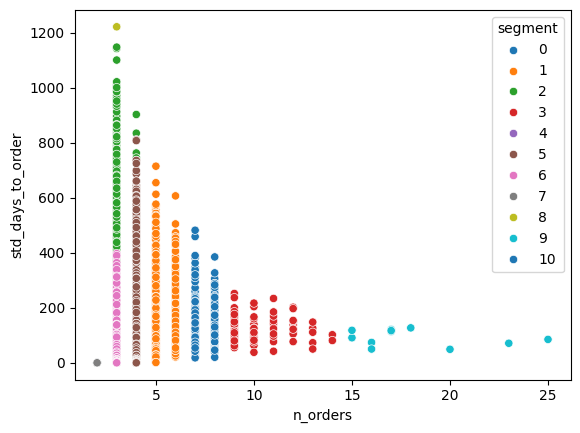

In [60]:
sns.scatterplot(repeat_purchasers, x='n_orders', y='std_days_to_order', hue=Xy.segment, palette='tab10')

<Axes: xlabel='avg_days_to_order', ylabel='std_days_to_order'>

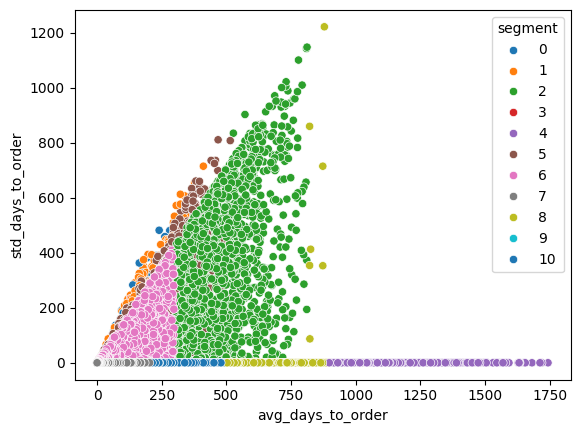

In [61]:
sns.scatterplot(repeat_purchasers, x='avg_days_to_order', y='std_days_to_order', hue=Xy.segment, palette='tab10')

In [62]:
repeat_purchasers.loc[:, ['n_orders', 'avg_days_to_order', 'std_days_to_order']]\
                 .groupby(kmeans_loyalty.labels_)\
                 .describe()\
                 .sort_values([('n_orders', 'mean'), 
                               ('avg_days_to_order', 'mean'), 
                               ('std_days_to_order', 'mean')])\
                 .transpose()

7            0            4            8   \
n_orders          count  6679.000000  3763.000000  1004.000000  2215.000000   
                  mean      2.000000     2.000000     2.000000     2.003160   
                  std       0.000000     0.000000     0.000000     0.056140   
                  min       2.000000     2.000000     2.000000     2.000000   
                  25%       2.000000     2.000000     2.000000     2.000000   
                  50%       2.000000     2.000000     2.000000     2.000000   
                  75%       2.000000     2.000000     2.000000     2.000000   
                  max       2.000000     2.000000     2.000000     3.000000   
avg_days_to_order count  6679.000000  3763.000000  1004.000000  2215.000000   
                  mean     79.989519   337.123572  1111.013944   665.736343   
                  std      62.216987    84.983433   174.814922   108.714647   
                  min       0.000000   209.000000   890.000000   502.000000   
                  25%      23.000000   261.000000   970.000000   572.000000   
                  50%      70.000000   327.000000  1073.000000   651.000000   
                  75%     131.000000   409.000000  1223.250000   750.000000   
                  max     208.000000   501.000000  1744.000000   889.000000   
std_days_to_order count  6679.000000  3763.000000  1004.000000  2215.000000   
                  mean      0.000000     0.000000     0.000000     1.807675   
                  std       0.000000     0.000000     0.000000    37.808855   
                  min       0.000000     0.000000     0.000000     0.000000   
                  25%       0.000000     0.000000     0.000000     0.000000   
                  50%       0.000000     0.000000     0.000000     0.000000   
                  75%       0.000000     0.000000     0.000000     0.000000   
                  max       0.000000     0.000000     0.000000  1222.000000   

                                  6            2            5           1   \
n_orders          count  3213.000000  1731.000000  2226.000000  785.000000   
                  mean      3.000000     3.011554     4.000000    5.301911   
                  std       0.000000     0.106898     0.000000    0.459379   
                  min       3.000000     3.000000     4.000000    5.000000   
                  25%       3.000000     3.000000     4.000000    5.000000   
                  50%       3.000000     3.000000     4.000000    5.000000   
                  75%       3.000000     3.000000     4.000000    6.000000   
                  max       3.000000     4.000000     4.000000    6.000000   
avg_days_to_order count  3213.000000  1731.000000  2226.000000  785.000000   
                  mean    135.956116   462.437897   202.135220  190.968153   
                  std      85.657156   120.201676   129.763034   87.833854   
                  min       0.000000   301.000000     0.000000    0.000000   
                  25%      63.000000   362.500000    94.000000  125.000000   
                  50%     130.000000   437.000000   186.500000  186.000000   
                  75%     206.000000   544.000000   298.750000  251.000000   
                  max     300.000000   812.000000   519.000000  437.000000   
std_days_to_order count  3213.000000  1731.000000  2226.000000  785.000000   
                  mean     98.549953   351.153668   171.821653  187.611465   
                  std      89.029035   224.257474   140.925130  117.844796   
                  min       0.000000     0.000000     0.000000    1.000000   
                  25%      25.000000   167.000000    60.000000   98.000000   
                  50%      74.000000   334.000000   139.000000  168.000000   
                  75%     149.000000   495.000000   246.750000  246.000000   
                  max     412.000000  1148.000000   811.000000  715.000000   

                                 10          3           9   
n_orders          count  189.000000   83.0000

In [63]:
loyalty_segment_map = {
    0: 'New Repeat Customer (Mid Days-to-Order)',
    1: 'Potential Loyal Customers',
    2: 'New Repeat Customer (High Days-to-Order)',
    3: 'Loyal Customer',
    4: 'New Repeat Customer (High Days-to-Order)',
    5: 'Potential Loyal Customers',
    6: 'New Repeat Customer (Low Days-to-Order)',
    7: 'New Repeat Customer (Low Days-to-Order)',
    8: 'New Repeat Customer (High Days-to-Order)',
    9: 'High-Frequency Loyal Customer',
    10: 'Loyal Customer',
}

In [64]:
repeat_purchasers['loyalty_segment'] = Xy.segment.map(loyalty_segment_map)

In [65]:
repeat_purchasers.loyalty_segment.value_counts()

loyalty_segment
New Repeat Customer (Low Days-to-Order)     9892
New Repeat Customer (High Days-to-Order)    4950
New Repeat Customer (Mid Days-to-Order)     3763
Potential Loyal Customers                   3011
Loyal Customer                               272
High-Frequency Loyal Customer                 11
Name: count, dtype: int64

<Axes: xlabel='n_orders', ylabel='avg_days_to_order'>

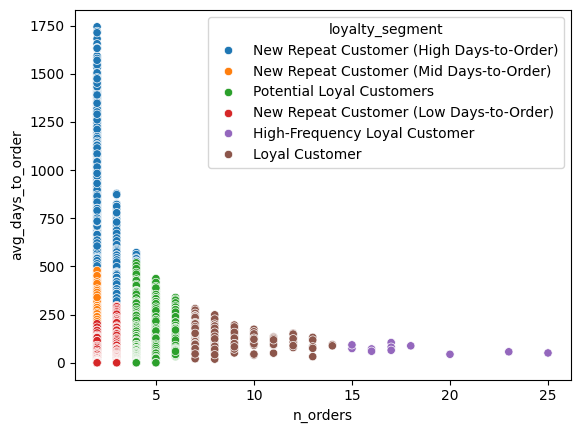

In [66]:
sns.scatterplot(repeat_purchasers, x='n_orders', y='avg_days_to_order', hue='loyalty_segment', palette='tab10')

<Axes: xlabel='n_orders', ylabel='std_days_to_order'>

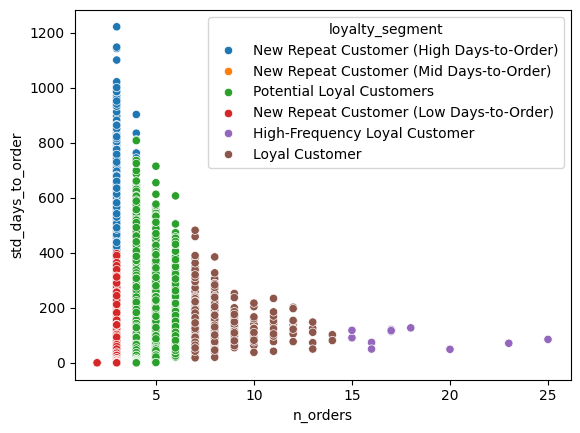

In [67]:
sns.scatterplot(repeat_purchasers, x='n_orders', y='std_days_to_order', hue='loyalty_segment', palette='tab10')

## Order Value

In [68]:
X_order_value = repeat_purchasers[['avg_order_items', 'max_order_items', 'avg_item_value', 'max_item_value']].copy() # Add min / max
X_order_value

,avg_order_items,max_order_items,avg_item_value,max_item_value
1,1.0,1.0,221.500000,399.00
3,1.0,1.0,35.975000,51.96
5,1.0,2.0,49.598571,135.00
8,1.0,2.0,34.620000,52.00
10,2.0,2.0,25.090000,34.99
...,...,...,...,...
83994,2.0,3.0,67.798333,239.00
83996,2.0,4.0,40.238571,59.50
84003,2.0,2.0,107.663333,228.00
84004,1.0,1.0,82.555000,149.03


In [69]:
scaler_order_value = RobustScaler()
X_order_value_scaled = scaler_order_value.fit_transform(X_order_value)
X_order_value_scaled

array([[ 0.        , -1.        ,  4.75511156,  3.33387097],
       [ 0.        , -1.        , -0.42495991, -0.39774194],
       [ 0.        ,  0.        , -0.04457412,  0.49516129],
       ...,
       [ 1.        ,  0.        ,  1.57666084,  1.49516129],
       [ 0.        , -1.        ,  0.87560729,  0.64602151],
       [ 1.        ,  0.        ,  0.99615685,  2.00053763]],
      shape=(21899, 4))

In [70]:
pca_order_value = PCA(n_components='mle')
X_order_value_pca = pca_order_value.fit_transform(X_order_value_scaled)
X_order_value_pca

array([[ 4.94676201, -2.38829037,  0.82121947],
       [-1.16915598, -0.86512445, -0.13908157],
       [-0.08743691, -0.18151313, -0.55029769],
       ...,
       [ 1.80775783, -0.15384753,  0.26601495],
       [ 0.44253878, -1.25324835,  0.03371269],
       [ 1.78061964, -0.03242219, -0.43196754]], shape=(21899, 3))

In [71]:
hyperparams = [{'n_clusters': i} for i in range(2, 21)]
kmeans_results_order_value = search_clustering_hyperparams(KMeans, hyperparams, X_order_value_pca, random_state=RANDOM_STATE)

{'n_clusters': 2, 'random_state': 42} | Silhouette Score: 0.41248223693094255 | Error: 54678.93918325129
{'n_clusters': 3, 'random_state': 42} | Silhouette Score: 0.39266358782750155 | Error: 36592.48229348541
{'n_clusters': 4, 'random_state': 42} | Silhouette Score: 0.44403642822033096 | Error: 26005.244105392405
{'n_clusters': 5, 'random_state': 42} | Silhouette Score: 0.40822329695552456 | Error: 20700.98207309722
{'n_clusters': 6, 'random_state': 42} | Silhouette Score: 0.4135984226136932 | Error: 17142.063653231653
{'n_clusters': 7, 'random_state': 42} | Silhouette Score: 0.4219364712627113 | Error: 15213.410469421928
{'n_clusters': 8, 'random_state': 42} | Silhouette Score: 0.4286610573730082 | Error: 13054.935179619137
{'n_clusters': 9, 'random_state': 42} | Silhouette Score: 0.4106314997901531 | Error: 11836.206876639924
{'n_clusters': 10, 'random_state': 42} | Silhouette Score: 0.41064595696145884 | Error: 10756.921562262225
{'n_clusters': 11, 'random_state': 42} | Silhouette 

<Axes: title={'center': 'Silhouette Score'}, xlabel='n_clusters'>

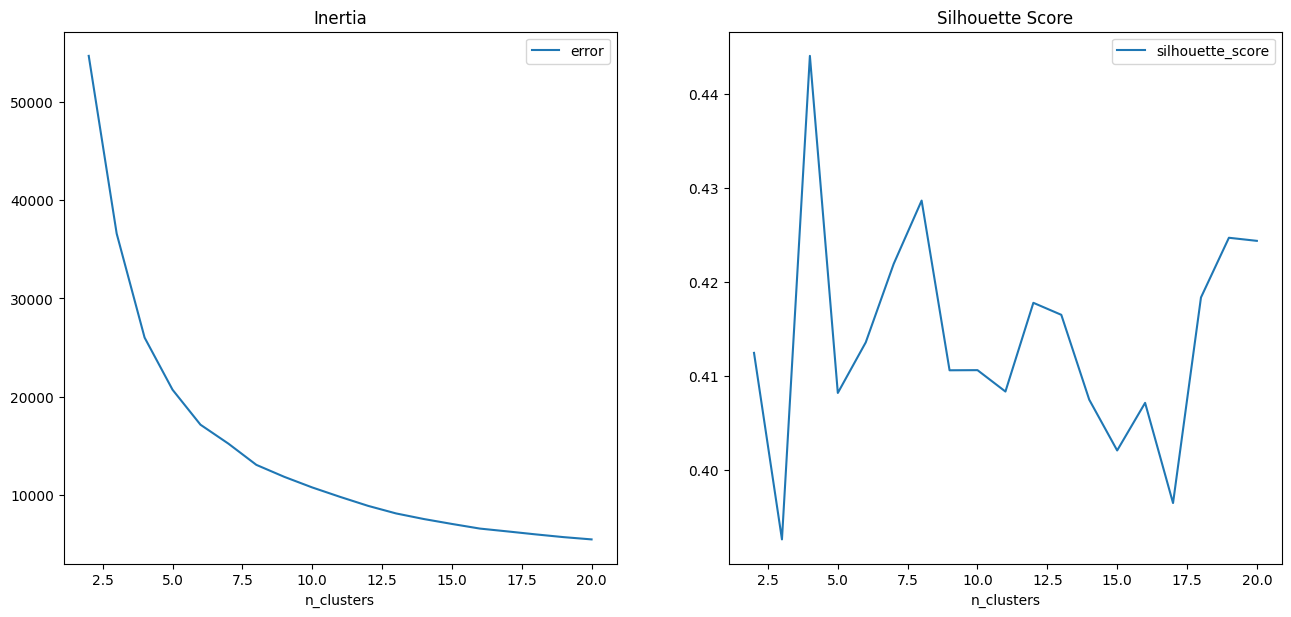

In [72]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.set_figheight(7)
plt.tight_layout(pad=5)

axs[0].set_title('Inertia')
kmeans_results_order_value.plot(x='n_clusters', y='error', ax=axs[0])

axs[1].set_title('Silhouette Score')
kmeans_results_order_value.plot(x='n_clusters', y='silhouette_score', ax=axs[1])

In [73]:
kmeans_order_value = kmeans_results_order_value.loc[kmeans_results_order_value.n_clusters==4, 'model'].iloc[0]
Xy = X_order_value.copy()
Xy['segment'] = kmeans_order_value.labels_
repeat_purchasers['segment'] = kmeans_order_value.labels_

In [74]:
Xy['segment'].value_counts()

segment
0    12617
1     4891
2     4102
3      289
Name: count, dtype: int64

In [75]:
cluster_centers = pca_order_value.inverse_transform(kmeans_order_value.cluster_centers_)
cluster_centers = scaler_order_value.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(cluster_centers, columns=['avg_order_items', 'max_order_items', 'avg_item_value', 'max_item_value'])
cluster_centers.sort_values(['avg_order_items', 'max_order_items', 'avg_item_value', 'max_item_value'])

,avg_order_items,max_order_items,avg_item_value,max_item_value
0,1.265688,1.471386,43.772173,67.645303
3,1.364521,2.288453,245.570599,678.455930
2,1.398368,1.621263,103.227470,206.364717
1,2.478127,3.469931,53.397854,129.372084


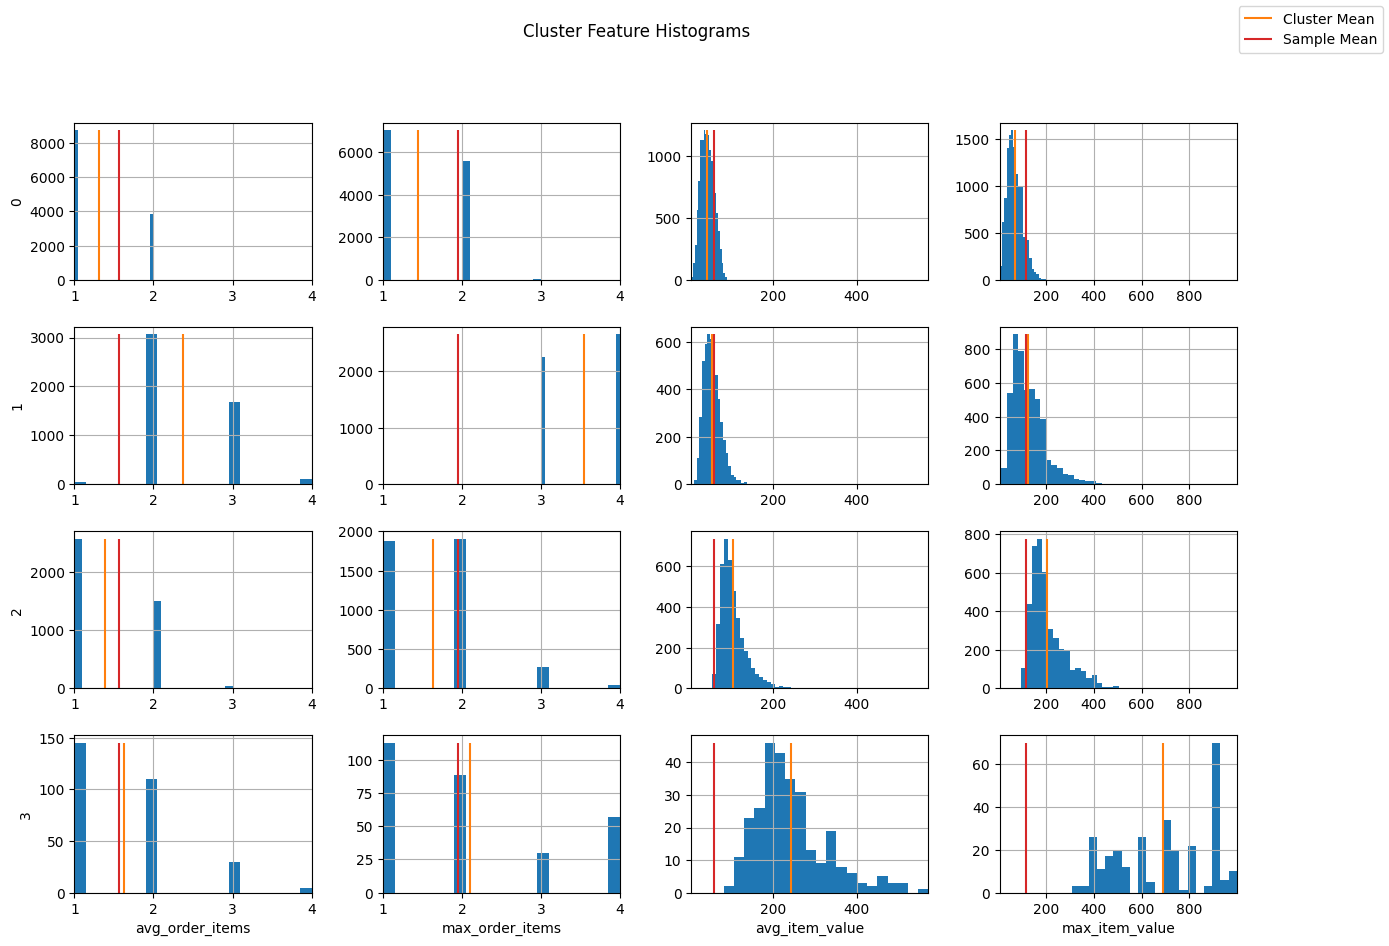

In [76]:
plot_clusters(X_order_value, kmeans_order_value.labels_)

<Axes: xlabel='avg_order_items', ylabel='avg_item_value'>

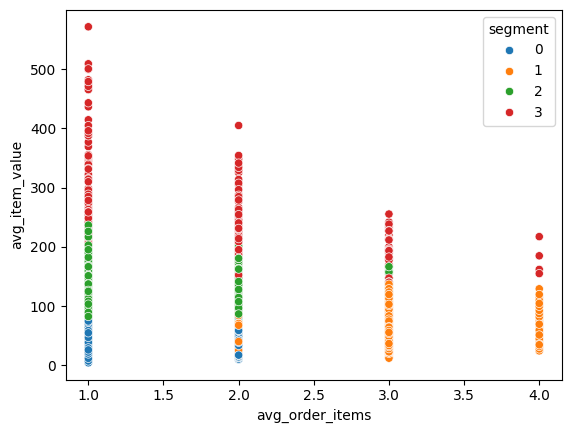

In [77]:
sns.scatterplot(Xy, x='avg_order_items', y='avg_item_value', hue='segment', palette='tab10')

<Axes: xlabel='avg_order_items', ylabel='max_item_value'>

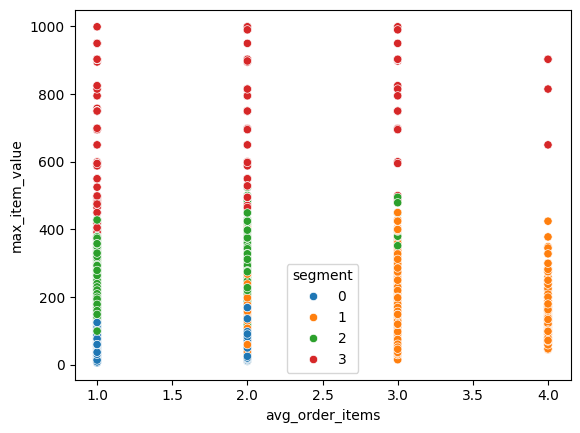

In [78]:
sns.scatterplot(Xy, x='avg_order_items', y='max_item_value', hue='segment', palette='tab10')

<Axes: xlabel='max_order_items', ylabel='avg_item_value'>

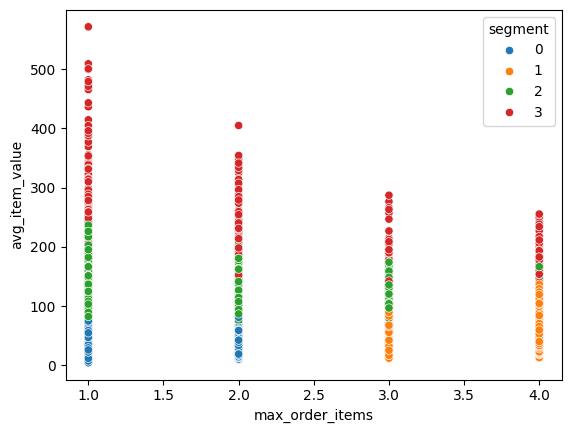

In [79]:
sns.scatterplot(Xy, x='max_order_items', y='avg_item_value', hue='segment', palette='tab10')

<Axes: xlabel='max_order_items', ylabel='max_item_value'>

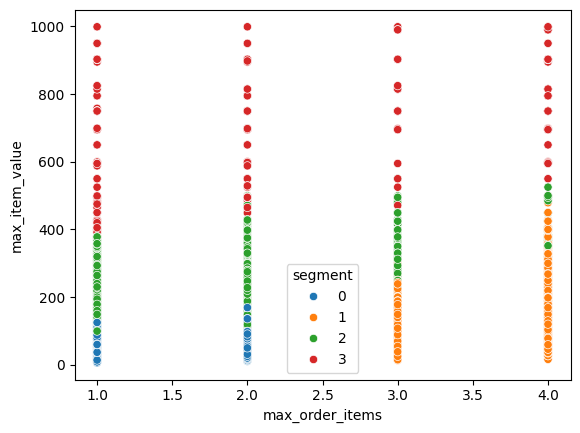

In [80]:
sns.scatterplot(Xy, x='max_order_items', y='max_item_value', hue='segment', palette='tab10')

<Axes: xlabel='avg_item_value', ylabel='max_item_value'>

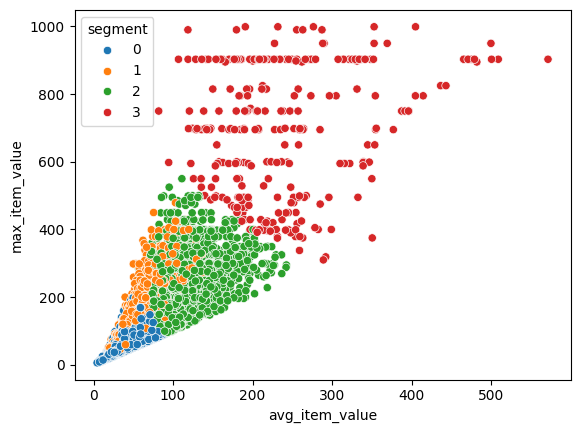

In [81]:
sns.scatterplot(Xy, x='avg_item_value', y='max_item_value', hue='segment', palette='tab10')

<Axes: xlabel='n_orders', ylabel='avg_item_value'>

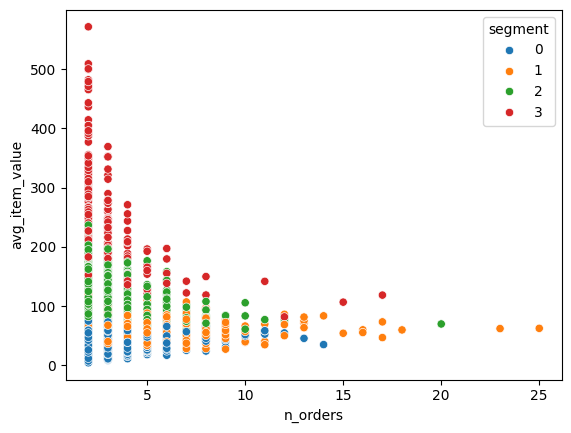

In [82]:
sns.scatterplot(repeat_purchasers, x='n_orders', y='avg_item_value', hue='segment', palette='tab10')

<Axes: xlabel='n_orders', ylabel='max_item_value'>

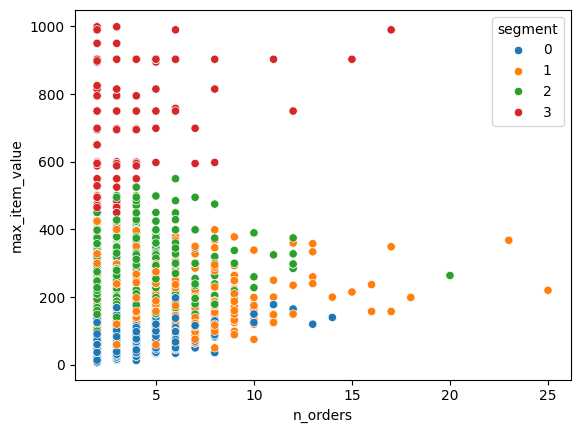

In [83]:
sns.scatterplot(repeat_purchasers, x='n_orders', y='max_item_value', hue='segment', palette='tab10')

<Axes: xlabel='n_orders', ylabel='avg_order_items'>

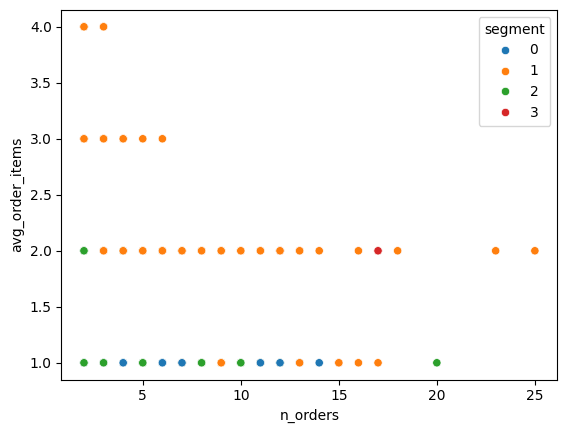

In [84]:
sns.scatterplot(repeat_purchasers, x='n_orders', y='avg_order_items', hue='segment', palette='tab10')

<Axes: xlabel='n_orders', ylabel='max_order_items'>

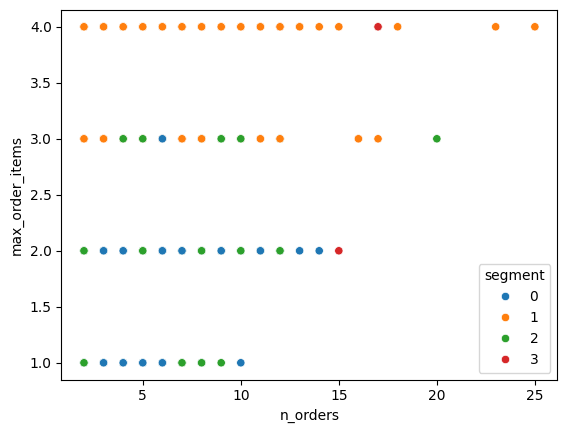

In [85]:
sns.scatterplot(repeat_purchasers, x='n_orders', y='max_order_items', hue='segment', palette='tab10')

In [86]:
order_value_segment_map = {
    0: 'Ordering Low Value',
    1: 'Ordering Multiple Mid-Value Items',
    2: 'Ordering Mid-/High-Value Items',
    3: 'Ordering High Value Items'
}

In [87]:
repeat_purchasers['order_value_segment'] = Xy['segment'].map(order_value_segment_map) 

# Segmenting Customers by Categories

In [88]:
X_cats = X[['n_categories', 'fav_cat_purchases', 'fav_cat_freq_strength', 'fav_cat_spending_strength']]
X_cats.head(10)

,n_categories,fav_cat_purchases,fav_cat_freq_strength,fav_cat_spending_strength
1,2.0,1.0,0.500000,0.900677
3,2.0,1.0,0.500000,0.722168
5,4.0,3.0,0.428571,0.529969
8,3.0,1.0,0.250000,0.375505
10,2.0,2.0,0.666667,0.535140
18,5.0,1.0,0.200000,0.627560
19,4.0,1.0,0.200000,0.340154
26,5.0,1.0,0.200000,0.321637
34,7.0,2.0,0.222222,0.273849
36,4.0,1.0,0.250000,0.366704


In [181]:
X_cats = X_cats[X_cats.fav_cat_purchases>1]
X_cats.shape[0], repeat_purchasers.shape[0]

(4441, 21899)

In [90]:
scaler_category = RobustScaler()
X_cats_scaled = scaler_category.fit_transform(X_cats)
X_cats_scaled

array([[ 0.33333333,  1.        ,  0.13333333,  0.05514101],
       [-0.33333333,  0.        ,  1.24444444,  0.0723612 ],
       [ 1.33333333,  0.        , -0.82962963, -0.79777895],
       ...,
       [ 1.        ,  0.        , -0.7       ,  0.14232701],
       [ 0.        ,  2.        ,  0.8       , -0.18198422],
       [ 0.        ,  0.        ,  0.46666667,  1.16520366]],
      shape=(4441, 4))

In [134]:
pca_cats = PCA(n_components='mle')
X_cats_pca = pca_cats.fit_transform(X_cats_scaled)
X_cats_pca

array([[ 0.20883848,  0.31205094,  0.75789255],
       [ 1.11509328, -0.58178786,  0.17524045],
       [-1.18990911,  0.93714542, -0.2168836 ],
       ...,
       [-0.46121047,  0.79610111, -0.45110302],
       [ 0.62331191,  0.1252639 ,  1.93699163],
       [ 1.18003816, -0.01379174, -0.39554604]], shape=(4441, 3))

In [167]:
hyperparams = [{'n_clusters': i} for i in range(2, 21)]
kmeans_results_category = search_clustering_hyperparams(KMeans, hyperparams, X_cats_scaled, random_state=RANDOM_STATE)

{'n_clusters': 2, 'random_state': 42} | Silhouette Score: 0.573389600069383 | Error: 5658.271530157837
{'n_clusters': 3, 'random_state': 42} | Silhouette Score: 0.4894737580668355 | Error: 2852.1629515739414
{'n_clusters': 4, 'random_state': 42} | Silhouette Score: 0.43978184078239185 | Error: 2089.5510813797955
{'n_clusters': 5, 'random_state': 42} | Silhouette Score: 0.4665314833959719 | Error: 1725.9473174337813
{'n_clusters': 6, 'random_state': 42} | Silhouette Score: 0.4488396069943826 | Error: 1429.7894988894582
{'n_clusters': 7, 'random_state': 42} | Silhouette Score: 0.45700121325574905 | Error: 1261.19562274966
{'n_clusters': 8, 'random_state': 42} | Silhouette Score: 0.45438530630974955 | Error: 1089.6032319602787
{'n_clusters': 9, 'random_state': 42} | Silhouette Score: 0.4592000943294806 | Error: 980.5673421982101
{'n_clusters': 10, 'random_state': 42} | Silhouette Score: 0.458537501695806 | Error: 892.9564172904181
{'n_clusters': 11, 'random_state': 42} | Silhouette Score:

<Axes: title={'center': 'Silhouette Score'}, xlabel='n_clusters'>

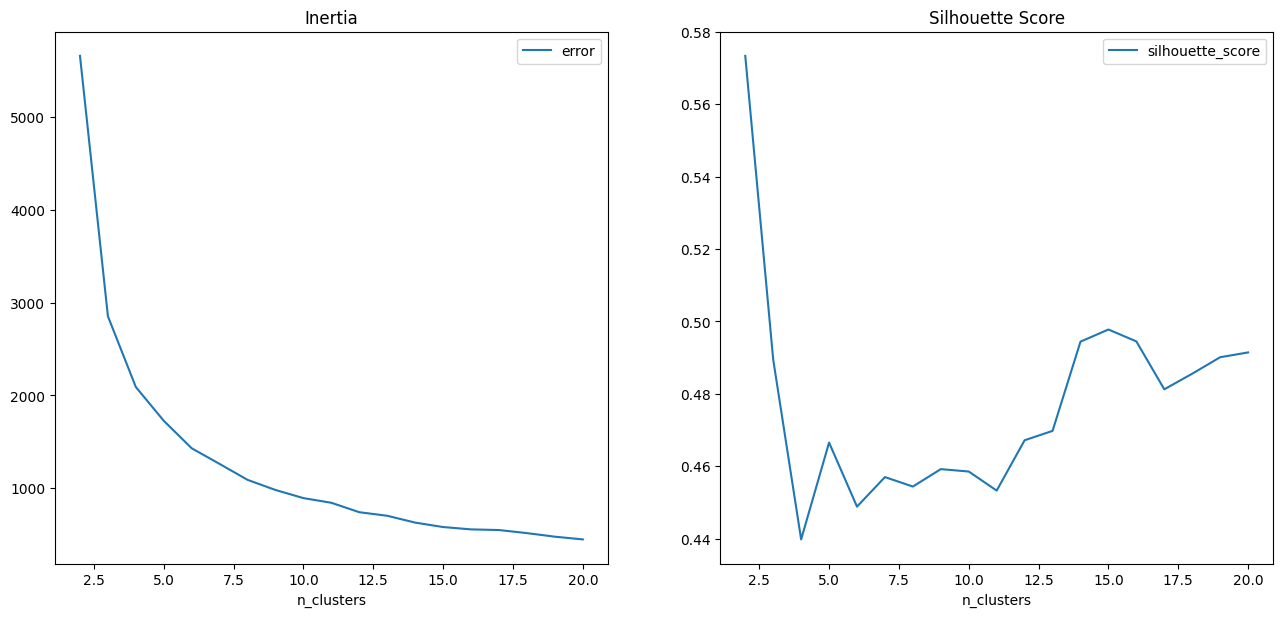

In [168]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.set_figheight(7)
plt.tight_layout(pad=5)

axs[0].set_title('Inertia')
kmeans_results_category.plot(x='n_clusters', y='error', ax=axs[0])

axs[1].set_title('Silhouette Score')
kmeans_results_category.plot(x='n_clusters', y='silhouette_score', ax=axs[1])

In [169]:
kmeans_category = kmeans_results_category.loc[kmeans_results_category.n_clusters==5, 'model'].iloc[0]
Xy = X_cats.copy()
Xy['segment'] = kmeans_category.labels_

In [170]:
Xy.segment.value_counts()

segment
1    1537
2    1032
3     996
0     533
4     343
Name: count, dtype: int64

In [173]:
columns = X_cats.columns.tolist()
# cluster_centers = pca_cats.inverse_transform(kmeans_category.cluster_centers_)
# cluster_centers = scaler_category.inverse_transform(cluster_centers)
cluster_centers = scaler_category.inverse_transform(kmeans_category.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns=columns)
cluster_centers.sort_values(cluster_centers.columns.tolist())

,n_categories,fav_cat_purchases,fav_cat_freq_strength,fav_cat_spending_strength
0,1.000000,2.050657,1.054712e-15,-5.551115e-16
2,2.170543,2.080426,6.430556e-01,7.566436e-01
1,3.583225,2.000000,4.260651e-01,5.507240e-01
4,4.263158,3.236842,4.876383e-01,5.455025e-01
3,6.392570,2.134538,2.603835e-01,3.822946e-01


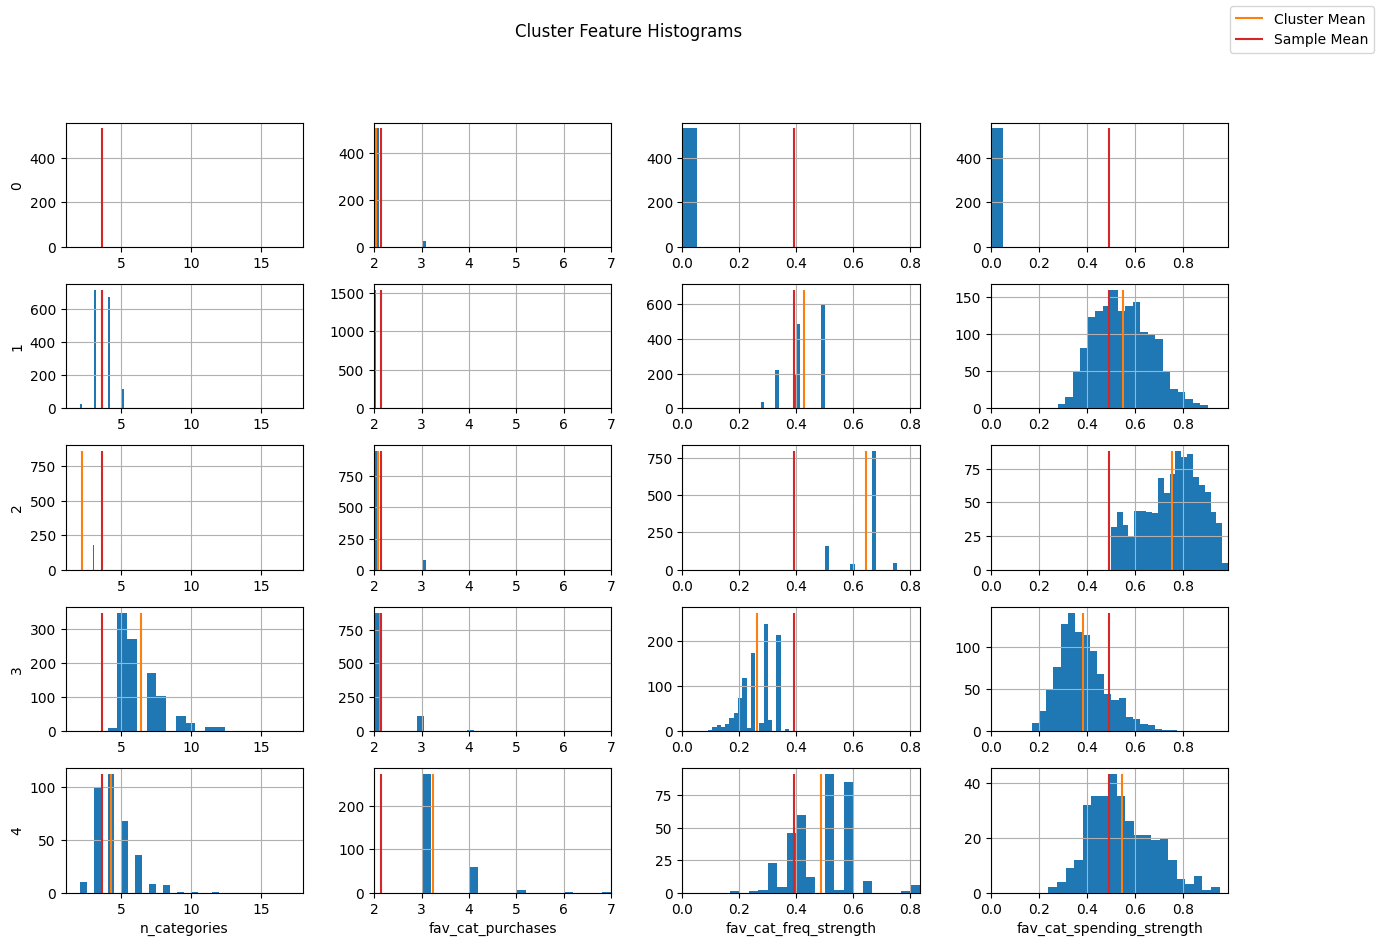

In [174]:
plot_clusters(X_cats, kmeans_category.labels_)

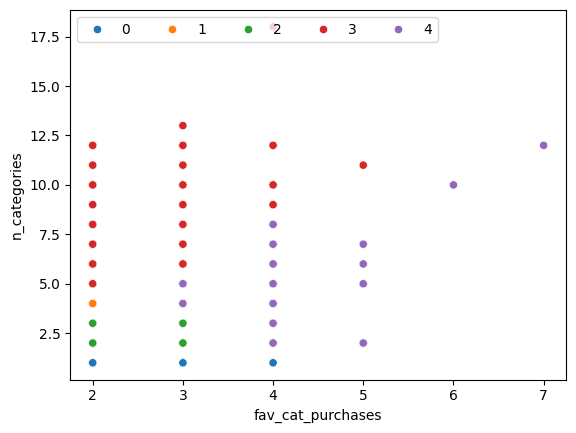

In [175]:
sns.scatterplot(Xy, x='fav_cat_purchases', y='n_categories', hue='segment', palette='tab10')
plt.legend(loc='upper left', ncol=Xy.segment.nunique())

<Axes: xlabel='fav_cat_freq_strength', ylabel='fav_cat_spending_strength'>

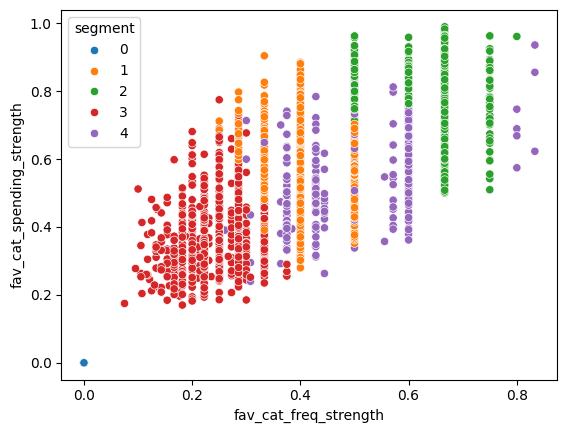

In [176]:
sns.scatterplot(Xy, x='fav_cat_freq_strength', y='fav_cat_spending_strength', hue='segment', palette='tab10')

In [189]:
category_segment_map = {
    0: 'Single Category',
    1: 'Multi-Category, Fav. Cat Mid Impact',
    2: 'Multi-Category, Fav. Cat High Impact (Few Purchases)',
    3: 'Multi-Category, Fav. Cat Mid-Impact',
    4: 'Multi-Category, Fav. Cat High Impact (Repeated Purchases)'
}

In [200]:
repeat_purchasers.category_choice_segment = Xy.segment.map(category_segment_map)
repeat_purchasers.loc[(repeat_purchasers.fav_cat_purchases==1)&
                        (repeat_purchasers.n_categories>1), 
                        'category_choice_segment'] = 'Multi-Category, Fav. Cat No Impact'
repeat_purchasers.loc[(repeat_purchasers.fav_cat_purchases==1)&
                        (repeat_purchasers.n_categories==1), 
                        'category_choice_segment'] = 'Single Item'

In [204]:
repeat_purchasers.category_choice_segment.unique()

array(['Multi-Category, Fav. Cat No Impact',
       'Multi-Category, Fav. Cat High Impact (Repeated Purchases)',
       'Multi-Category, Fav. Cat High Impact (Few Purchases)',
       'Multi-Category, Fav. Cat Mid-Impact', 'Single Category',
       'Multi-Category, Fav. Cat Mid Impact'], dtype=object)

# Analyzing Segments

In [203]:
total_spent = repeat_purchasers.n_orders * repeat_purchasers.avg_order_value
total_spent_groups = total_spent.groupby([repeat_purchasers.loyalty_segment, 
                                          repeat_purchasers.order_value_segment, 
                                          repeat_purchasers.category_choice_segment])\
                                .describe()\
                                .reset_index()\
                                .sort_values(['count', 'mean'], ascending=False)
                                
total_spent_groups.head(10)

KeyError: 'count'

In [1228]:
total_spent_groups.loc[~total_spent_groups.loyalty_segment.str.startswith('New')]

,loyalty_segment,order_value_segment,category_choice_segment,count,mean,std,min,25%,50%,75%,max
59,Potential Loyal Customers,Ordering Low Value,Purchasing Various Categories,1055.0,244.597886,90.540649,45.43,178.2500,235.370,298.6700,563.29
65,Potential Loyal Customers,Ordering Multiple Mid-Value Items,Purchasing Various Categories,894.0,461.920201,168.271593,140.20,336.1225,444.340,565.8450,1172.25
62,Potential Loyal Customers,Ordering Mid-/High-Value Items,Purchasing Various Categories,347.0,527.828357,186.517173,255.56,399.1650,488.940,618.3950,1478.35
57,Potential Loyal Customers,Ordering Low Value,"Purchasing Multiple Cats, Spending More on Fav...",261.0,237.404559,70.642708,80.98,184.9400,239.490,290.9700,392.88
60,Potential Loyal Customers,Ordering Mid-/High-Value Items,"Purchasing Multiple Cats, Spending More on Fav...",199.0,503.773920,151.797622,292.97,386.3100,459.970,593.9200,949.59
8,Loyal Customer,Ordering Multiple Mid-Value Items,Purchasing Various Categories,149.0,798.012349,290.495835,291.84,577.4000,750.310,953.9600,1924.74
63,Potential Loyal Customers,Ordering Multiple Mid-Value Items,"Purchasing Multiple Cats, Spending More on Fav...",101.0,388.651881,113.836109,144.11,319.0600,369.840,448.3700,700.24
61,Potential Loyal Customers,Ordering Mid-/High-Value Items,"Purchasing Multiple Cats, Spending Mostly on F...",61.0,369.653770,90.595464,256.70,293.8400,344.250,432.3500,605.68
7,Loyal Customer,Ordering Mid-/High-Value Items,Purchasing Various Categories,60.0,823.760000,251.013057,508.47,638.4325,723.390,981.4875,1461.83
5,Loyal Customer,Ordering Low Value,Purchasing Various Categories,52.0,476.067692,133.655499,178.51,399.8725,465.035,554.3000,761.89


In [1229]:
repeat_purchasers.groupby(['loyalty_segment'])['id'].count()

loyalty_segment
High-Frequency Loyal Customer                 11
Loyal Customer                               272
New Repeat Customer (High Days-to-Order)    4950
New Repeat Customer (Low Days-to-Order)     9892
New Repeat Customer (Mid Days-to-Order)     3763
Potential Loyal Customers                   3011
Name: id, dtype: int64

In [1230]:
repeat_purchasers.groupby(['order_value_segment'])['id'].count()

order_value_segment
Ordering High Value Items              289
Ordering Low Value                   12617
Ordering Mid-/High-Value Items        4102
Ordering Multiple Mid-Value Items     4891
Name: id, dtype: int64

In [1232]:
repeat_purchasers.groupby(['category_choice_segment'])['id'].count()

category_choice_segment
Purchasing Multiple Cats, Spending More on Fav. Cat.       4957
Purchasing Multiple Cats, Spending Mostly on Fav. Cat.     5343
Purchasing Single Category                                  533
Purchasing Various Categories                             11066
Name: id, dtype: int64

<Axes: xlabel='n_orders', ylabel='None'>

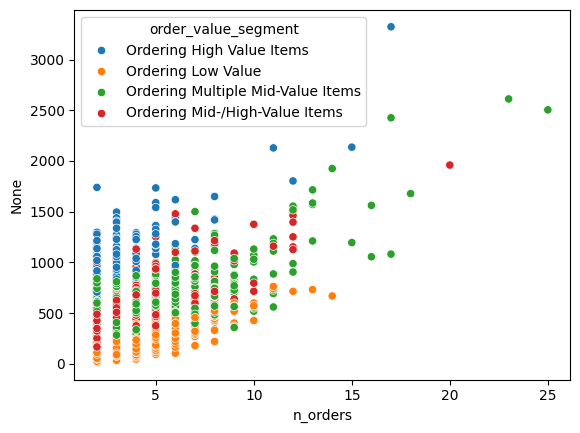

In [1233]:
sns.scatterplot(repeat_purchasers, x='n_orders', y=total_spent, hue='order_value_segment', palette='tab10')

<Axes: xlabel='avg_days_to_order', ylabel='None'>

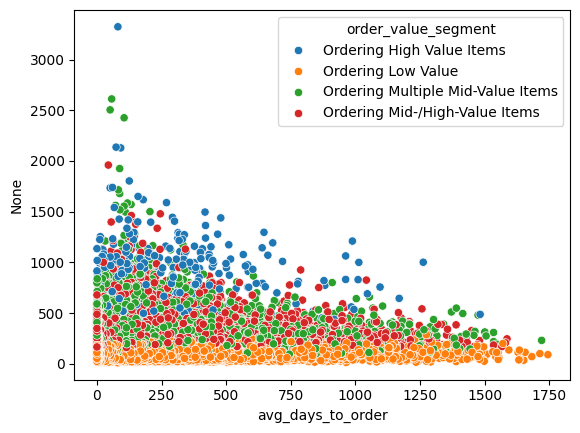

In [1234]:
sns.scatterplot(repeat_purchasers, x='avg_days_to_order', y=total_spent, hue='order_value_segment', palette='tab10')

In [1239]:
repeat_purchasers['segment'] = repeat_purchasers.loyalty_segment + ' - ' + repeat_purchasers.order_value_segment + ' - ' + repeat_purchasers.category_choice_segment

In [1241]:
customers_segmented = pd.concat([repeat_purchasers, one_off_customers, inactive_users])\
                        .sort_values('created_at')

In [1249]:
customers_segmented.groupby(['segment'])['id'].count().sort_values(ascending=False).head(20)

segment
One-Off Customers                                                                                                                     36394
Never Ordered                                                                                                                         25718
New Repeat Customer (Low Days-to-Order) - Ordering Low Value - Purchasing Various Categories                                           2600
New Repeat Customer (Low Days-to-Order) - Ordering Low Value - Purchasing Multiple Cats, Spending Mostly on Fav. Cat.                  1570
New Repeat Customer (Low Days-to-Order) - Ordering Low Value - Purchasing Multiple Cats, Spending More on Fav. Cat.                    1539
New Repeat Customer (Low Days-to-Order) - Ordering Multiple Mid-Value Items - Purchasing Various Categories                            1412
New Repeat Customer (High Days-to-Order) - Ordering Low Value - Purchasing Various Categories                                          1256
Potential Lo

<Axes: >

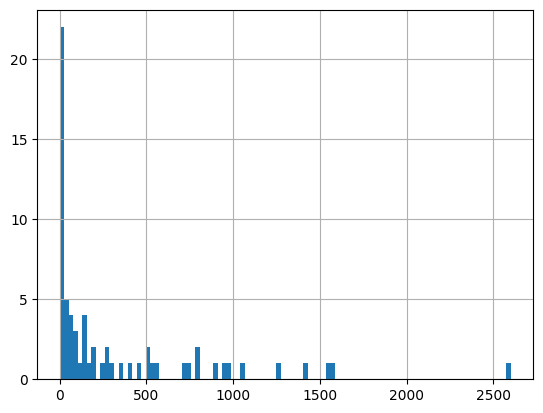

In [1254]:
repeat_purchasers.groupby(['segment'])['id'].count().hist(bins=100)

## Saving Pipelines

In [196]:
loyalty_segment_pipe = Pipeline([('scaler', scaler_loyalty), ('kmeans', kmeans_loyalty)])
order_value_segment_pipe = Pipeline([('scaler', scaler_order_value), ('pca', pca_order_value), ('kmeans', kmeans_order_value)])

In [197]:
# with open('../models/loyalty_segment_pipe.pkl', 'wb') as f:
#     pkl.dump(loyalty_segment_pipe, f)
# 
# with open('../models/order_value_segment_pipe.pkl', 'wb') as f:
#     pkl.dump(order_value_segment_pipe, f)

In [198]:
with open('../models/loyalty_segment_pipe.pkl', 'rb') as f:
    loyalty_segment_pipe_loaded = pkl.load(f)

with open('../models/order_value_segment_pipe.pkl', 'rb') as f:
    order_value_segment_pipe_loaded = pkl.load(f)

In [199]:
loyalty_labels = loyalty_segment_pipe_loaded.predict(X_loyalty)
(loyalty_labels == kmeans_loyalty.labels_).all()

np.True_

In [201]:
order_value_labels = order_value_segment_pipe_loaded.predict(X_order_value)
(order_value_labels == kmeans_order_value.labels_).all()

np.True_

In [202]:
with open('../models/loyalty_segment_map.json', 'w') as f:
    json.dump(loyalty_segment_map, f)

with open('../models/order_value_segment_map.json', 'w') as f:
    json.dump(order_value_segment_map, f)

In [203]:
with open('../models/loyalty_segment_map.json', 'r') as f:
    loyalty_segment_map_loaded = json.load(f)

with open('../models/order_value_segment_map.json', 'r') as f:
    order_value_segment_map_loaded = json.load(f)

In [204]:
loyalty_segment_map_loaded

{'0': 'New Repeat Customer (Mid Days-to-Order)',
 '1': 'Potential Loyal Customers',
 '2': 'New Repeat Customer (High Days-to-Order)',
 '3': 'Loyal Customer',
 '4': 'New Repeat Customer (High Days-to-Order)',
 '5': 'Potential Loyal Customers',
 '6': 'New Repeat Customer (Low Days-to-Order)',
 '7': 'New Repeat Customer (Low Days-to-Order)',
 '8': 'New Repeat Customer (High Days-to-Order)',
 '9': 'High-Frequency Loyal Customer',
 '10': 'Loyal Customer'}

In [205]:
order_value_segment_map_loaded

{'0': 'Ordering Low Value',
 '1': 'Ordering Multiple Mid-Value Items',
 '2': 'Ordering Mid-/High-Value Items',
 '3': 'Ordering High Value Items'}